In [82]:
from Bio import pairwise2
from Bio.Seq import Seq
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns 
import random
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import scipy.cluster.hierarchy as shc
from matplotlib.colors import ListedColormap

In [83]:
species = "horse"
bed_file = 'horse/'+'sep1_244_sorted.bed' # contains loci for all sep1 coordinates
results_file = 'horse/'+'v2output_sep1.txt'# contains VCF info for every sample that has SV in one of the identified coordinates

In [84]:
ere1_1 = Seq("GACCAGTGTGGGGGGGCTGGCCCCGTGGCCGAGTGGTTAAGTTCGCGCGCTCTGCTGCAGGCGGCCCAGT \
            GTTTCGTTGGTTCGAATCCTGGGCGCGGACATGGCACTGCTCATCAAAACCAGGCTGAGGCGGCGTCCCA \
            CATACCACAACTAGAAGAATCCACAACGAAGAATATACAACTATGTACCGGGGGGCTTTGGGGAGAAAAA \
            GGAAATAATAAAATCTTTAAAAAAAAAAAAAAAAAAAAAGACCAGTGTG")
ere1_2 = Seq("AAATGGGGGCTGGCCCCGTGGCCAAGTGCGTTAAGTTCGCGCCCTCCACTGCAGGGAGGCCCAGTGTTTC \
            GTTGGTTCGAATCCTGGGCGCGGACATGGCACTTGCTCATCAAACCACTCTAGGCAGCGTCCACATGCCA \
            CAACTGAAGGCCCACAATGAGAATATACAACTATGTCCGGAGTCTTGGGAAGAAAAAGGAAAAAAAAATT \
            TAATCTTAAACAAAAAAGAAAAATG")
ere1_3 = Seq("GGTTGAGGGGCTGGCCCCGTGGCAAGTGGTTAAGTTCTCGAGCTCCGCTGCAGGCAGCCCAGTGTTTCGT \
            TGGTTTGAATCCTGGGCGTGGACATGGCACTGCTCATCAAACCATGCTGAGTCGGCGTCCCACATGCCAC \
            AACTAGAAGACCCACAACTAGGAATATACAACTATGTACTGGGGGGCTTTGGGGAGAAAAGAGGAAAAAA \
            ATGAAATCTTTAAAAAAAGAAAAAAAGGTTGAG")
ere1_4 = Seq("ATTCCACAACTAGGGGCTGGCCCCATGGCCAAGTGGTTAAGTTCGCACGTTCCGCTGCAGGCGCTCAGTG \
            TTTCGTTGGTTTGAATCCTGGGCACGGACGTGGCACTGCTCATCAAACCACGCTGAGGCAGCGTCCCACA \
            TGCCACAACTAGAAGGACCCACAACGAAGAATATACAACTATGTACTGGGGGGCTTTGGGAAGAAAAAGG \
            AAAAGAATAAAATCTTAAAAAAAAAAATATTCCCAACTA")
ere1_5 = Seq("GGCTTTTCAGGGGGCTGGCCCGTGGCTGAGTGGTTAAGTTCGCGCACTCCGCTGCAAGCGGCCCAGTGTT \
            TCGTTGGTTCGAATCCTGGAGGTGGACATGGCACTGCTCGGTCAGACCCACGCTGAGGCAGCGTCCCACA \
            TGCCACAACTAGAAGGACCCACAATGAAGAATATACAACTATGTACTGGGGGGCTTTGGGGAGAAAGAGG \
            AAAAAATAAAATCTTTAAAAAAAAAAAAAGGCTTTTCA")

colors = {'PRZEWALSKI' : 'red', 'AKHAL-TEKE' : 'blue', 'ARABIAN' : 'green', \
          'QUARTER HORSE' : 'yellow', "MONGOLIAN" : "brown", "THOROUGHBRED" : 'orange', \
          'FRIESIAN' : 'black', 'HANOVARIAN' : 'pink', 'JEJU HORSE' : 'gray', \
          'CURLY HORSE' : 'purple', 'DEBAO' : 'teal', 'CRIOLLO' : 'tan'}


In [85]:
# get all loci
entries = []
with open(bed_file) as f:
    lines = f.readlines()
    for line in lines: #
        line = line.split()
        end = int(line[1]) + int(line[2])
        t = ">"+line[0]+":"+line[1]+"-"+str(line[1])
        entries.append(t)
meta_data = pd.read_csv('horse/horse_sra_simple.csv')
#print(meta_data)
meta_data.columns = ['sra','breed']
color_col = []
for index, row in meta_data.iterrows():
    row['breed'] = row['breed'] + str(random.randint(0,9))

In [91]:
samples = {}
index = 0
with open(results_file) as f:
    lines = f.readlines()
    for line in lines:
        if "output" in line:
            sample_name = line.split('/')[1].strip()
            breed_name = meta_data.loc[meta_data['sra'] == sample_name]
            #print(breed_name, sample_name)
            breed_name = breed_name['breed'].values[0]
            samples[breed_name] = np.zeros(len(entries)) 
        else:
            t = line.split()
            chrom = t[0]
            start = t[1]
            end = start
            seq = re.search('SVINSSEQ=(.*);SPLIT_READS',line)
            seq = seq.group(1)
            s = ">"+chrom+":"+start+"-"+end
            if s in entries and chrom not in  ['X', 'Y']: # SV is in TE loci, get percent identify to cons seq
                idx = entries.index(s)
                scores = []
                scores.append(pairwise2.align.globalxx(ere1_1, Seq(seq), score_only = True))
                scores.append(pairwise2.align.globalxx(ere1_2, Seq(seq), score_only = True))
                scores.append(pairwise2.align.globalxx(ere1_3, Seq(seq), score_only = True))
                scores.append(pairwise2.align.globalxx(ere1_4, Seq(seq), score_only = True))
                scores.append(pairwise2.align.globalxx(ere1_5, Seq(seq), score_only = True))
                max_value = max(scores)
                if max_value < 138: 
                    max_index = 5
                else:
                    max_index = scores.index(max_value)
                    #max_index = 0
                samples[breed_name][idx] = max_index + 1

In [92]:
df=pd.DataFrame.from_dict(samples,orient='index').transpose()

In [93]:
#df = df.loc[:, ~df.columns.str.startswith('QUARTER')]
#df = df.loc[:, ~df.columns.str.startswith('FRIESIAN')]
#df = df.loc[:, ~df.columns.str.startswith('MONGOLIAN')]
#df = df.loc[:, ~df.columns.str.startswith('PRZ')]
#df = df.loc[:, ~df.columns.str.startswith('THOROUGH')]
#df = df.loc[:, ~df.columns.str.startswith('CRIOLLO')]
#df = df.loc[:, ~df.columns.str.startswith('DEBAO')]
#df = df.loc[:, ~df.columns.str.startswith('HANOV')]
#df = df.loc[:, ~df.columns.str.startswith('JEJU')]
#df = df.loc[:, ~df.columns.str.startswith('CURLY')]
#df = df.loc[:, ~df.columns.str.startswith('AKHAL')]
#df = df.loc[:, ~df.columns.str.startswith('ARAB')]

cols = list(df.columns.values)
cols = sorted(cols, key=str.lower)
df_new = df[cols]
df_final = df_new.iloc[0:905]
df_final = df_final.transpose()

In [94]:
cmap_dict = {0: 'black', 1: 'orange', 2: 'blue', 3: 'red', 4: 'green', 5 : 'yellow', 6 : 'pink'}
#cmap_dict = {0: 'black', 1: 'orange', 2: 'blue', 3: 'red', 4: 'lawngreen', 5 : 'purple'}
#cmap_dict = {0: 'black', 1: 'black', 2 : 'red'}
cmap = ListedColormap([cmap_dict[i] for i in range(7)])

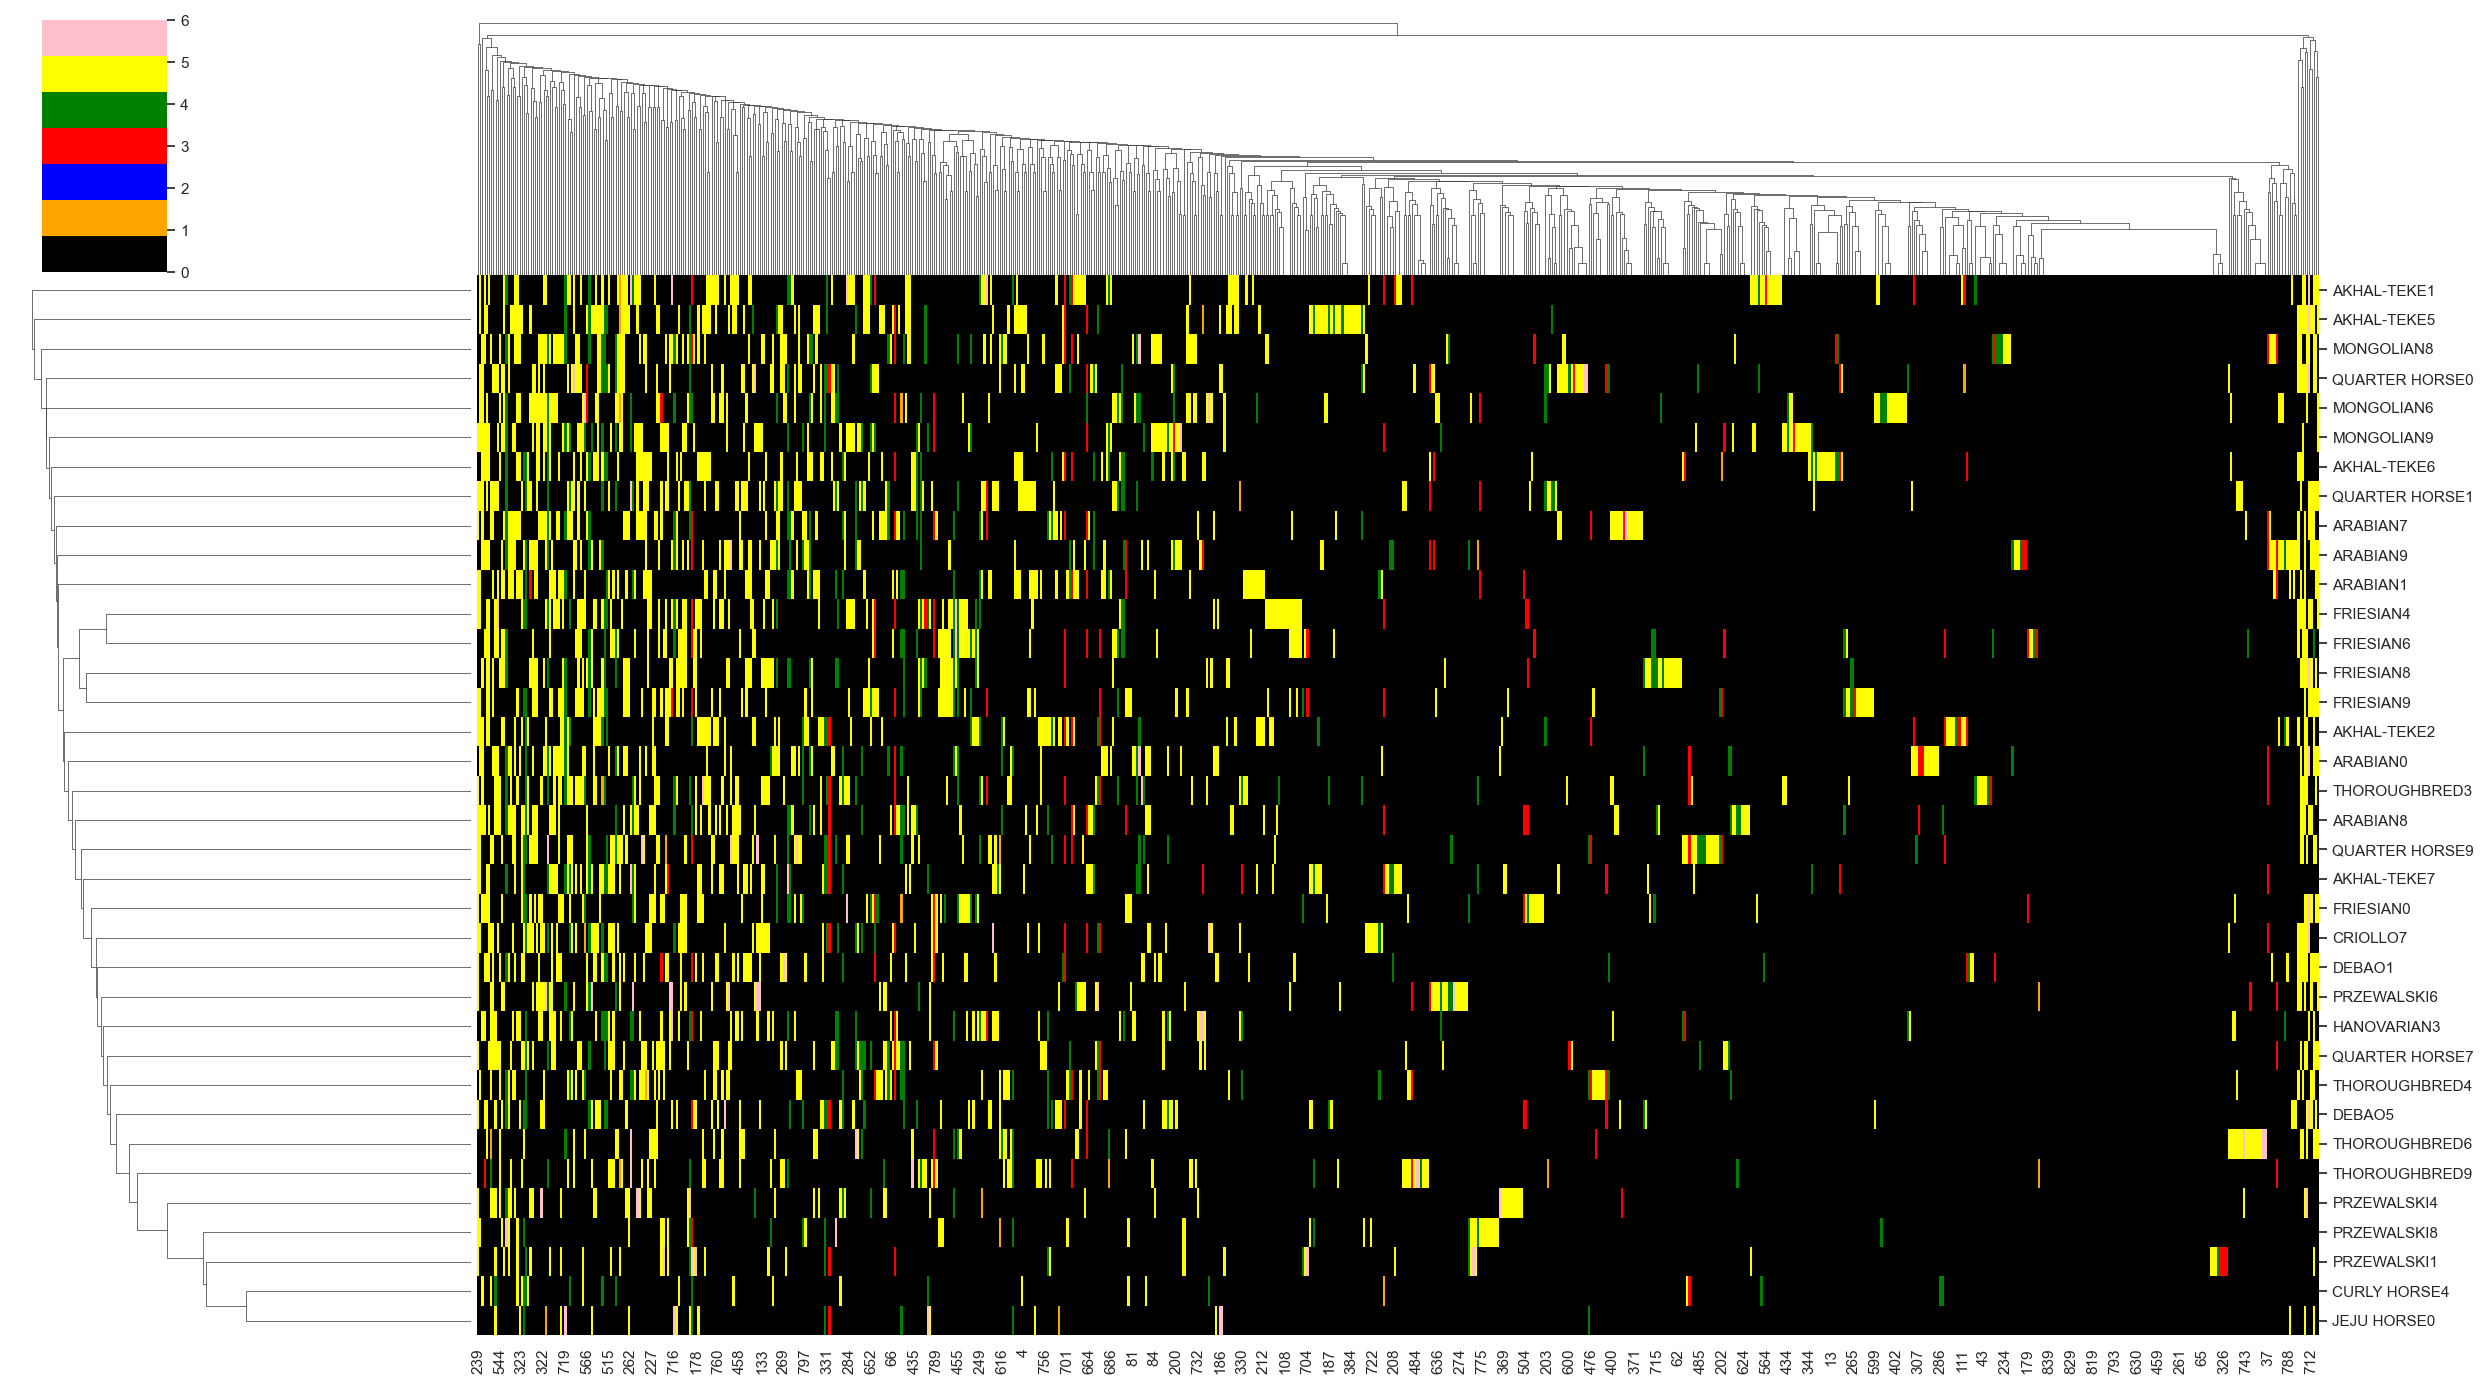

In [98]:
#from matplotlib.colors import ListedColormap
#plt.subplots(figsize=(27,15))
ls = sns.clustermap(df_final, cmap=cmap, figsize=(25,14))
fig = ls.fig
fig.savefig("ered1.png") 

In [80]:
X = df_final.loc[:].values
x_scaled = StandardScaler().fit_transform(X)
y = list(df_final.index)
pca = PCA(n_components=2)
pca_features = pca.fit_transform(x_scaled)
## Create dataframe
pca_df = pd.DataFrame(
    data=pca_features, 
    columns=['PC1', 'PC2'])
pca_df['target'] = y
t = list(pca_df['target'].values)
cs = [colors[i[:-1]] for i in t] 
pca_df['colors'] = cs
c_dict = dict(zip(pca_df.target, pca_df.colors))
#print(pca_df)

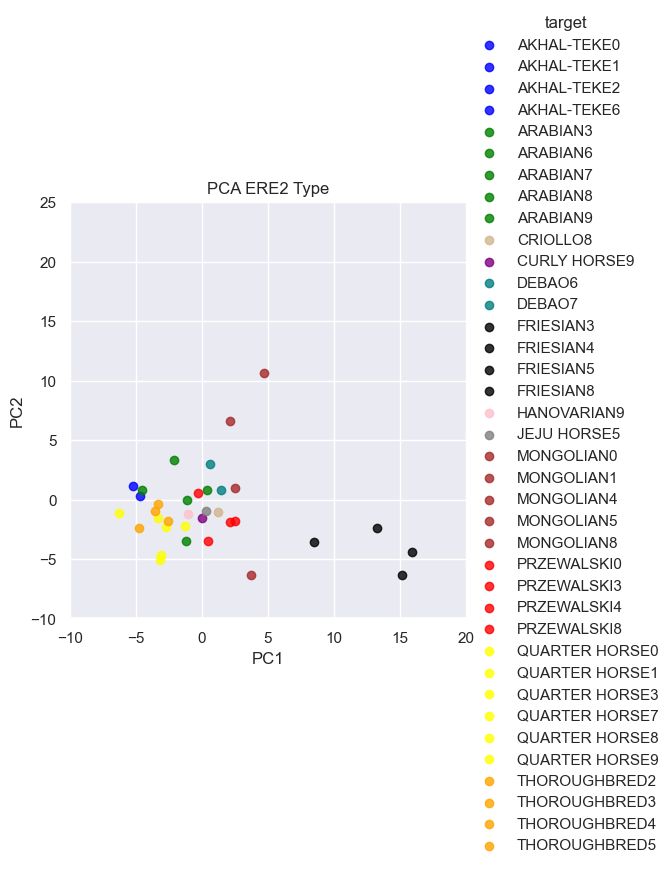

In [81]:
import seaborn as sns
sns.set()
 
ls = sns.lmplot(
    x='PC1', 
    y='PC2', 
    data=pca_df, 
    palette=c_dict,
    hue='target',
    fit_reg=False, 
    legend=True
    )
ls = (ls.set_axis_labels("PC1","PC2").set(xlim=(-10,20),ylim=(-10,25)))
plt.title('PCA ERE2 Type')
plt.show()

In [35]:
#x = df_final.apply(pd.Series.value_counts)
#x = x.drop(0)
#print(x)
#data = x.T
#print(data)
#y = data.values
#data[0:100].plot.bar(stacked=True, title='The number of Students')
#print(y)
#x = np.array(data.index)
#x = x[0:100]
#y1 =y[0:100,1]
#y2 =y[0:100,2]